In [1]:
#general imports that we will need will almost always use - it is a good practice to import all libraries at the beginning of the notebook or script
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# data partition
from sklearn.model_selection import train_test_split

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE


# embedded methods
from sklearn.linear_model import LassoCV

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

#set random seed for reproducibility
RSEED = 42
np.random.seed(RSEED)

In [2]:
def load_data(filepath: str): 
    """
    Load any dataset from a CSV file into a pandas DataFrame.
    
    Args:
        filepath (str): Path to the CSV file
        
    Returns:
        pd.DataFrame: Loaded dataset
    """
    df = pd.read_csv(filepath)
    return df

In [3]:
df = load_data("train.csv")
df.T

,0,1,2,3,4,5,6,7,8,9,...,75963,75964,75965,75966,75967,75968,75969,75970,75971,75972
carID,69512,53000,6366,29021,10062,14704,6924,50783,67071,23348,...,67221,41090,16023,60263,44131,37194,6265,54886,860,15795
Brand,VW,Toyota,Audi,Ford,BMW,BMW,Audi,Skoda,VW,Ford,...,VW,Mercedes,Ford,Opel,Mercedes,Mercedes,Audi,Toyota,Audi,Ford
model,Golf,Yaris,Q2,FIESTA,2 Series,3 Series,A3,Octavia,Passat,Focus,...,T-Roc,GLC Class,EcoSport,Crossland X,GLC Class,C Class,Q3,Aygo,Q3,Fiesta
year,2016.0,2019.0,2019.0,2018.0,2019.0,2014.0,2017.0,2017.0,2017.0,2019.0,...,2020.0,2016.0,2017.0,2018.0,2018.0,2015.0,2013.0,2017.0,2015.0,2018.0
price,22290,13790,24990,12500,22995,8199,16089,7500,15999,15300,...,25785,24486,10498,13995,30495,13498,12495,8399,12990,10495
transmission,Semi-Auto,Manual,Semi-Auto,anual,Manual,anual,Manual,Manual,Semi-Auto,Manual,...,Semi-Auto,NaN,Manual,Manual,Semi-Auto,Manual,Semi-Auto,Automatic,Manual,Manual
mileage,28421.0,4589.0,3624.0,9102.0,1000.0,101153.348285,21396.0,116750.0,30339.0,10700.0,...,10.0,22955.0,13613.0,1800.0,11943.0,14480.0,52134.0,11304.0,69072.0,16709.0
fuelType,Petrol,Petrol,Petrol,Petrol,Petrol,Diesel,Petrol,Diesel,Diesel,Petrol,...,Petrol,Diesel,Petrol,Petrol,Diesel,etrol,Diesel,Petrol,iesel,Petro
tax,NaN,145.0,145.0,145.0,145.0,30.0,20.0,145.0,150.0,150.0,...,145.0,125.0,125.0,150.0,150.0,125.0,200.0,145.0,125.0,145.0
mpg,11.417268,47.9,40.9,65.7,42.8,65.7,60.1,68.9,62.8,60.1,...,39.8,56.5,88.32164,57.7,56.5,53.3,47.9,67.0,60.1,64.2


In [4]:
def get_unique_values(df):
    # Get unique values for each column as lists
    unique_values_dict = {column: df[column].unique().tolist() for column in df.columns}
    
    # Find the maximum length of unique values
    max_length = max(len(values) for values in unique_values_dict.values())
    
    # Determine padding value based on column type
    padded_dict = {}
    for column, values in unique_values_dict.items():
        # Check if column is numeric (int or float)
        if pd.api.types.is_numeric_dtype(df[column]):
            padding_value = np.nan
        else:
            padding_value = None
        # Pad the list to max_length
        padded_dict[column] = values + [padding_value] * (max_length - len(values))
    
    # Convert padded dictionary to DataFrame
    unique_df = pd.DataFrame(padded_dict)
    
    return unique_df

In [5]:
def get_unique_column_values(df, column_name):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame. Available columns: {list(df.columns)}")
    if pd.api.types.is_object_dtype(df[column_name]) or pd.api.types.is_string_dtype(df[column_name]):
        values = df[column_name].astype(str).str.strip().replace('nan', np.nan).unique()
    else:
        values = df[column_name].unique()
    return [x for x in values.tolist() if pd.notna(x) and x is not None]

In [6]:
get_unique_values(df).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           72 non-null     object 
 2   model           735 non-null    object 
 3   year            44 non-null     float64
 4   price           11048 non-null  float64
 5   transmission    40 non-null     object 
 6   mileage         34808 non-null  float64
 7   fuelType        34 non-null     object 
 8   tax             65 non-null     float64
 9   mpg             217 non-null    float64
 10  engineSize      58 non-null     float64
 11  paintQuality%   88 non-null     float64
 12  previousOwners  23 non-null     float64
 13  hasDamage       1 non-null      float64
dtypes: float64(9), int64(1), object(4)
memory usage: 8.1+ MB


## 1. Cleaning Data

### Model - Data Cleaning

In [7]:
def clean_categorical(dirty_data, mapping, print_unique=False):
    """
    Clean a Pandas Series or iterable of categorical data using a mapping dictionary.
    
    Args:
        dirty_data: Pandas Series or iterable containing categorical values to clean.
        mapping: Dictionary mapping incorrect variations (lowercase) to standardized values.
        print_unique: Bool, if True, prints unique cleaned values (excluding None).
    
    Returns:
        pandas.Series or list: Cleaned data with same type as input (Series if input is Series, else list).
    
    Raises:
        ValueError: If dirty_data is not iterable, mapping is not provided, not a dictionary, or empty.
    """
    import pandas as pd

    # Validate inputs
    if dirty_data is None:
        raise ValueError("dirty_data must be provided")
    if mapping is None:
        raise ValueError("mapping must be provided")
    if not isinstance(mapping, dict):
        raise ValueError("mapping must be a dictionary")
    if not mapping:
        raise ValueError("mapping cannot be empty")
    
    # Check if dirty_data is iterable (excluding strings)
    try:
        iter(dirty_data)
        if isinstance(dirty_data, str):
            raise ValueError("dirty_data cannot be a string")
    except TypeError:
        raise ValueError("dirty_data must be a Pandas Series or iterable")

    # Handle Series input
    if isinstance(dirty_data, pd.Series):
        # Filter non-None values and convert to list
        non_none_values = [str(value).strip() for value in dirty_data if pd.notna(value)]
        # Clean values: map variations to correct values, keep unmapped values unchanged
        cleaned_values = [mapping.get(value.lower(), value) for value in non_none_values]
        # Create output Series, aligning with original index
        result = pd.Series(index=dirty_data.index, dtype=object)
        idx = 0
        for i, value in dirty_data.items():
            if pd.notna(value):
                result[i] = cleaned_values[idx]
                idx += 1
            else:
                result[i] = value  # Preserve None or np.nan
        # Print unique cleaned values if requested
        if print_unique:
            unique_cleaned = sorted(set(v for v in cleaned_values if pd.notna(v)))
            print("Unique cleaned values:", unique_cleaned)
        return result
    
    # Handle list/iterable input
    cleaned_values = []
    for value in dirty_data:
        if pd.notna(value):
            cleaned_value = mapping.get(str(value).strip().lower(), str(value).strip())
            cleaned_values.append(cleaned_value)
        else:
            cleaned_values.append(value)  # Preserve None or np.nan
    # Print unique cleaned values if requested
    if print_unique:
        unique_cleaned = sorted(set(v for v in cleaned_values if pd.notna(v)))
        print("Unique cleaned values:", unique_cleaned)
    return cleaned_values

# Cleaning Brand

In [8]:
# Dictionary mapping variations to correct brand names
brand_mapping = {
    'vw': 'Volkswagen', 'v': 'Volkswagen', 'w': 'Volkswagen',
    'toyota': 'Toyota', 'toyot': 'Toyota', 'oyota': 'Toyota',
    'audi': 'Audi', 'aud': 'Audi', 'udi': 'Audi', 'ud': 'Audi',
    'ford': 'Ford', 'for': 'Ford', 'ord': 'Ford', 'or': 'Ford',
    'bmw': 'BMW', 'mw': 'BMW', 'bm': 'BMW',
    'skoda': 'Skoda', 'skod': 'Skoda', 'koda': 'Skoda', 'kod': 'Skoda',
    'opel': 'Opel', 'ope': 'Opel', 'pel': 'Opel', 'pe': 'Opel',
    'mercedes': 'Mercedes', 'mercede': 'Mercedes', 'ercedes': 'Mercedes', 
    'ercede': 'Mercedes',
    'hyundai': 'Hyundai', 'hyunda': 'Hyundai', 'yundai': 'Hyundai', 'yunda': 'Hyundai'
}

df["Brand"] = clean_categorical(df["Brand"],brand_mapping)
get_unique_values(df).info()
get_unique_column_values(df, "Brand")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           9 non-null      object 
 2   model           735 non-null    object 
 3   year            44 non-null     float64
 4   price           11048 non-null  float64
 5   transmission    40 non-null     object 
 6   mileage         34808 non-null  float64
 7   fuelType        34 non-null     object 
 8   tax             65 non-null     float64
 9   mpg             217 non-null    float64
 10  engineSize      58 non-null     float64
 11  paintQuality%   88 non-null     float64
 12  previousOwners  23 non-null     float64
 13  hasDamage       1 non-null      float64
dtypes: float64(9), int64(1), object(4)
memory usage: 8.1+ MB


['Volkswagen',
 'Toyota',
 'Audi',
 'Ford',
 'BMW',
 'Skoda',
 'Opel',
 'Mercedes',
 'Hyundai']

## Cleaning Model

In [9]:
get_unique_values(df).info()
#get_unique_column_values(df, "model")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           9 non-null      object 
 2   model           735 non-null    object 
 3   year            44 non-null     float64
 4   price           11048 non-null  float64
 5   transmission    40 non-null     object 
 6   mileage         34808 non-null  float64
 7   fuelType        34 non-null     object 
 8   tax             65 non-null     float64
 9   mpg             217 non-null    float64
 10  engineSize      58 non-null     float64
 11  paintQuality%   88 non-null     float64
 12  previousOwners  23 non-null     float64
 13  hasDamage       1 non-null      float64
dtypes: float64(9), int64(1), object(4)
memory usage: 8.1+ MB


In [10]:
# Define known model-to-brand mapping
model_to_brand = {
    # Volkswagen
    'Golf': 'Volkswagen',
    'Polo': 'Volkswagen',
    'Passat': 'Volkswagen',
    'Tiguan': 'Volkswagen',
    'T-Roc': 'Volkswagen',
    'T-Cross': 'Volkswagen',
    'Touran': 'Volkswagen',
    'Touareg': 'Volkswagen',
    'Sharan': 'Volkswagen',
    'Scirocco': 'Volkswagen',
    'Jetta': 'Volkswagen',
    'Beetle': 'Volkswagen',
    'Arteon': 'Volkswagen',
    'Amarok': 'Volkswagen',
    'Caddy': 'Volkswagen',
    'Caddy Maxi': 'Volkswagen',
    'Caddy Maxi Life': 'Volkswagen',
    'Caddy Life': 'Volkswagen',
    'Golf Sv': 'Volkswagen',
    'Tiguan Allspace': 'Volkswagen',
    'Eos': 'Volkswagen',
    'Cc': 'Volkswagen',
    'Fox': 'Volkswagen',
    'Shuttle': 'Volkswagen',
    'California': 'Volkswagen',
    'Caravelle': 'Volkswagen',
    'Up': 'Volkswagen',

    # Toyota
    'Yaris': 'Toyota',
    'Corolla': 'Toyota',
    'Auris': 'Toyota',
    'Aygo': 'Toyota',
    'Prius': 'Toyota',
    'Rav4': 'Toyota',
    'Land Cruiser': 'Toyota',
    'GT86': 'Toyota',
    'Supra': 'Toyota',
    'C-Hr': 'Toyota',
    'C-HR': 'Toyota',
    'Avensis': 'Toyota',
    'Verso': 'Toyota',
    'Verso-S': 'Toyota',
    'Camry': 'Toyota',
    'Hilux': 'Toyota',
    'Proace Verso': 'Toyota',
    'Urban Cruiser': 'Toyota',
    'IQ': 'Toyota',

    # Audi
    'A1': 'Audi',
    'A2': 'Audi',
    'A3': 'Audi',
    'A4': 'Audi',
    'A5': 'Audi',
    'A6': 'Audi',
    'A7': 'Audi',
    'A8': 'Audi',
    'Q2': 'Audi',
    'Q3': 'Audi',
    'Q5': 'Audi',
    'Q7': 'Audi',
    'Q8': 'Audi',
    'TT': 'Audi',
    'S3': 'Audi',
    'S4': 'Audi',
    'S5': 'Audi',
    'S8': 'Audi',
    'RS3': 'Audi',
    'RS4': 'Audi',
    'RS5': 'Audi',
    'RS6': 'Audi',
    'SQ5': 'Audi',
    'SQ7': 'Audi',
    'R8': 'Audi',

    # Ford
    'Fiesta': 'Ford',
    'Focus': 'Ford',
    'Kuga': 'Ford',
    'Mondeo': 'Ford',
    'EcoSport': 'Ford',
    'S-Max': 'Ford',
    'B-Max': 'Ford',
    'C-Max': 'Ford',
    'Grand C-Max': 'Ford',
    'Ka': 'Ford',
    'Ka+': 'Ford',
    'Mustang': 'Ford',
    'Edge': 'Ford',
    'Puma': 'Ford',
    'Ranger': 'Ford',
    'Escort': 'Ford',
    'Fusion': 'Ford',
    'Streetka': 'Ford',
    'Galaxy': 'Ford',
    'Tourneo Connect': 'Ford',
    'Tourneo Custom': 'Ford',
    'Grand Tourneo Connect': 'Ford',

    # BMW
    '1 Series': 'BMW',
    '2 Series': 'BMW',
    '3 Series': 'BMW',
    '4 Series': 'BMW',
    '5 Series': 'BMW',
    '6 Series': 'BMW',
    '7 Series': 'BMW',
    '8 Series': 'BMW',
    'X1': 'BMW',
    'X2': 'BMW',
    'X3': 'BMW',
    'X4': 'BMW',
    'X5': 'BMW',
    'X6': 'BMW',
    'X7': 'BMW',
    'Z3': 'BMW',
    'Z4': 'BMW',
    'M2': 'BMW',
    'M3': 'BMW',
    'M4': 'BMW',
    'M5': 'BMW',
    'M6': 'BMW',
    'I3': 'BMW',
    'I8': 'BMW',

    # Skoda
    'Octavia': 'Skoda',
    'Fabia': 'Skoda',
    'Rapid': 'Skoda',
    'Yeti': 'Skoda',
    'Yeti Outdoor': 'Skoda',
    'Superb': 'Skoda',
    'Scala': 'Skoda',
    'Kamiq': 'Skoda',
    'Kodiaq': 'Skoda',
    'Citigo': 'Skoda',
    'Roomster': 'Skoda',
    'Karoq': 'Skoda',

    # Opel / Vauxhall
    'Corsa': 'Opel',
    'Astra': 'Opel',
    'Insignia': 'Opel',
    'Mokka': 'Opel',
    'Mokka X': 'Opel',
    'Zafira': 'Opel',
    'Zafira Tourer': 'Opel',
    'Meriva': 'Opel',
    'Adam': 'Opel',
    'Crossland': 'Opel',
    'Crossland X': 'Opel',
    'Grandland': 'Opel',
    'Grandland X': 'Opel',
    'Viva': 'Opel',
    'Combo Life': 'Opel',
    'Antara': 'Opel',
    'Agila': 'Opel',
    'Ampera': 'Opel',
    'Cascada': 'Opel',
    'Vectra': 'Opel',
    'Gtc': 'Opel',
    'Tigra': 'Opel',
    'Vivaro': 'Opel',

    # Mercedes-Benz
    'A Class': 'Mercedes',
    'B Class': 'Mercedes',
    'C Class': 'Mercedes',
    'E Class': 'Mercedes',
    'S Class': 'Mercedes',
    'G Class': 'Mercedes',
    'Gla Class': 'Mercedes',
    'Glb Class': 'Mercedes',
    'Glc Class': 'Mercedes',
    'Gle Class': 'Mercedes',
    'Gls Class': 'Mercedes',
    'Sl Class': 'Mercedes',
    'Slk': 'Mercedes',
    'Clk': 'Mercedes',
    'Cls Class': 'Mercedes',
    'Cl Class': 'Mercedes',
    'Clc Class': 'Mercedes',
    'M Class': 'Mercedes',
    'X-Class': 'Mercedes',
    'V Class': 'Mercedes',
    'Cla Class': 'Mercedes',
    'Gl Class': 'Mercedes',

    # Hyundai
    'Tucson': 'Hyundai',
    'Santa Fe': 'Hyundai',
    'I10': 'Hyundai',
    'I20': 'Hyundai',
    'I30': 'Hyundai',
    'I40': 'Hyundai',
    'Ix20': 'Hyundai',
    'Ix35': 'Hyundai',
    'Kona': 'Hyundai',
    'Ioniq': 'Hyundai',
    'I800': 'Hyundai',
    'Getz': 'Hyundai',
    'Accent': 'Hyundai',
    'Terracan': 'Hyundai',
    'Veloster': 'Hyundai'
}

misspelling_model_corrections = {
    # Ford
    'fiesta': 'Fiesta',
    'fiest': 'Fiesta',
    'focu': 'Focus',
    'kug': 'Kuga',
    'monde': 'Mondeo',
    'ecospor': 'EcoSport',
    'b-ma': 'B-Max',
    'b max': 'B-Max',
    's-ma': 'S-Max',
    's max': 'S-Max',
    'c-ma': 'C-Max',
    'c max': 'C-Max',
    'grand c-ma': 'Grand C-Max',
    'grand c max': 'Grand C-Max',
    'grand tourneo connec': 'Grand Tourneo Connect',
    'tourneo custo': 'Tourneo Custom',
    'galax': 'Galaxy',
    'edg': 'Edge',
    'puma': 'Puma',
    'streetka': 'StreetKa',

    # Volkswagen
    'gol': 'Golf',
    'golf': 'Golf',
    'polo': 'Polo',
    'passa': 'Passat',
    'passat': 'Passat',
    't-ro':'T-Roc',
    't roc': 'T-Roc',
    'troc': 'T-Roc',
    't-roc': 'T-Roc',
    't ro': 'T-Roc',
    't rock': 'T-Roc',
    't cross': 'T-Cross',
    'tcross': 'T-Cross',
    't-cros': 'T-Cross',  # Added
    't cro': 'T-Cross',
    'tiguan allspac': 'Tiguan Allspace',
    'tiguan allspace': 'Tiguan Allspace',
    'tigua': 'Tiguan',
    'touare': 'Touareg',
    'toura': 'Touran',
    'touran': 'Touran',
    'shara': 'Sharan',
    'scirocc': 'Scirocco',
    'arteo': 'Arteon',
    'beetl': 'Beetle',
    'caravell': 'Caravelle',
    'caddy maxi lif': 'Caddy Maxi Life',
    'caddy maxi life': 'Caddy Maxi Life',
    'shuttle': 'Sharan',
    't': 'Up',
    'up': 'Up',
    'amaro': 'Amarok',  # Added
    'pol': 'Polo',      # Added

    # Toyota
    'yaris': 'Yaris',
    'yari': 'Yaris',
    'auris': 'Auris',
    'auri': 'Auris',
    'ayg': 'Aygo',
    'aygo': 'Aygo',
    'coroll': 'Corolla',
    'c-hr': 'C-HR',
    'c hr': 'C-HR',
    'c h': 'C-HR',
    'rav': 'RAV4',
    'land cruise': 'Land Cruiser',
    'urban cruise': 'Urban Cruiser',
    'hilu': 'Hilux',
    'vers': 'Verso',
    'verso s': 'Verso-S',
    'iq': 'IQ',

    # Opel / Vauxhall
    'astra': 'Astra',
    'astr': 'Astra',
    'corsa': 'Corsa',
    'cors': 'Corsa',
    'insignia': 'Insignia',
    'insigni': 'Insignia',
    'mokka': 'Mokka',
    'mokk': 'Mokka',
    'mokka x': 'Mokka X',
    'meriv': 'Meriva',
    'zafir': 'Zafira',
    'zafira toure': 'Zafira Tourer',
    'ada': 'Adam',
    'crossland x': 'Crossland X',
    'grandland x': 'Grandland X',
    'grandland': 'Grandland X',
    'viva': 'Viva',
    'combo lif': 'Combo Life',
    'gtc': 'GTC',
    'antara': 'Antara',
    'cascad': 'Cascada',
    'vivar': 'Vivaro',
    'viv': 'Vivaro',

    # Skoda
    'fabia': 'Fabia',
    'fabi': 'Fabia',
    'octavia': 'Octavia',
    'octavi': 'Octavia',
    'kodia': 'Kodiaq',
    'karo': 'Karoq',
    'karoq': 'Karoq',
    'kami': 'Kamiq',
    'kamiq': 'Kamiq',
    'citig': 'Citigo',
    'citigo': 'Citigo',
    'rapid': 'Rapid',
    'rapi': 'Rapid',
    'yeti outdoo': 'Yeti Outdoor',
    'yeti': 'Yeti',
    'yet': 'Yeti',
    'super': 'Superb',
    'scal': 'Scala',
    'roomste': 'Roomster',

    # Mercedes-Benz
    'a clas': 'A Class',
    'a class': 'A Class',
    'b clas': 'B Class',
    'b class': 'B Class',
    'c clas': 'C Class',
    'c class': 'C Class',
    'e clas': 'E Class',
    'e class': 'E Class',
    's clas': 'S Class',
    's class': 'S Class',
    'glc clas': 'GLC Class',
    'glc class': 'GLC Class',
    'gle clas': 'GLE Class',
    'gle class': 'GLE Class',
    'gls clas': 'GLS Class',
    'gls class': 'GLS Class',
    'cl clas': 'CL Class',
    'cl class': 'CL Class',
    'cla class': 'CLA Class',
    'cls clas': 'CLS Class',
    'cls class': 'CLS Class',
    'gl clas': 'GL Class',
    'gl class': 'GL Class',
    'glb clas': 'GLB Class',
    'glb class': 'GLB Class',
    'gla clas': 'GLA Class',
    'gla class': 'GLA Class',
    'm class': 'M Class',
    'm clas': 'M Class',
    'x-clas':'X-Class',
    'x-class': 'X-Class',
    'x class': 'X-Class',
    'x clas': 'X-Class',
    'v clas': 'V Class',
    'v class': 'V Class',
    'sl':'SL Class',
    'sl clas': 'SL Class',
    'sl class': 'SL Class',
    'slk': 'SLK',
    'clk': 'CLK',

    # Audi
    'a1': 'A1',
    'a2': 'A2',
    'a3': 'A3',
    'a4': 'A4',
    'a5': 'A5',
    'a6': 'A6',
    'a7': 'A7',
    'a8': 'A8',
    'q2': 'Q2',
    'q3': 'Q3',
    'q5': 'Q5',
    'q7': 'Q7',
    'q8': 'Q8',
    'tt': 'TT',
    's3': 'S3',
    's4': 'S4',
    's5': 'S5',
    'rs3': 'RS3',
    'rs4': 'RS4',
    'rs5': 'RS5',
    'rs6': 'RS6',
    'sq5': 'SQ5',
    'sq7': 'SQ7',
    'r8': 'R8',

    # BMW
    '1 series': '1 Series',
    '2 series': '2 Series',
    '3 series': '3 Series',
    '4 series': '4 Series',
    '5 series': '5 Series',
    '6 series': '6 Series',
    '7 series': '7 Series',
    '8 series': '8 Series',
    'x1': 'X1',
    'x2': 'X2',
    'x3': 'X3',
    'x4': 'X4',
    'x5': 'X5',
    'x6': 'X6',
    'x7': 'X7',
    'z3': 'Z3',
    'z4': 'Z4',
    'm2': 'M2',
    'm3': 'M3',
    'm4': 'M4',
    'm5': 'M5',
    'm6': 'M6',
    'i3': 'I3',
    'i8': 'I8',
    'ix2': 'IX20',
    'i': 'I10',
    'i10': 'I10',
    '1 serie': '1 Series',
    '2 serie': '2 Series',
    '3 serie': '3 Series',
    '4 serie': '4 Series',
    '5 serie': '5 Series',
    '6 serie': '6 Series',
    '7 serie': '7 Series',
    '8 serie': '8 Series',

    # Hyundai
    'tucso': 'Tucson',
    'tucson': 'Tucson',
    'santa f': 'Santa Fe',
    'i1': 'I10',
    'i2': 'I20',
    'i20': 'I20',
    'i30': 'I30',
    'i40': 'I40',
    'ix20': 'IX20',
    'ix35': 'IX35',
    'ioni': 'Ioniq',
    'i80': 'I800',
    'getz': 'Getz',
    'accent': 'Accent',
    'terracan': 'Terracan',
    'kon': 'Kona',    # Added
    'kona': 'Kona',   # Added
    'veloste': 'Veloster',  # Added
}





# Models to ignore during brand matching — too vague or incomplete to map reliably
unknown_models = {
    'A',      # Too vague; could be a typo for Audi A1–A8 or Mercedes A Class
    'Q',      # Too vague; likely a typo for Audi Q-series (Q2, Q3, Q5, etc.)
    'X',      # Too vague; could be BMW X-series (X1, X3, etc.) or Mercedes X-Class
    'K',      # Possibly a typo for Ford Kuga or Skoda Kodiaq
    'U',      # Possibly a typo for Volkswagen Up
    'Z',      # Possibly a typo for BMW Z3 or Z4
    'M',      # Could be BMW M-series (M2, M3, M4, etc.)
    'Golf S', # Likely a trim of Volkswagen Golf (e.g., Golf S), not a distinct model
    'Kadjar', # Renault Kadjar – not in our brand set
    'RS',     # Too vague; likely a typo for Audi RS model (e.g., RS3, RS4)
    '220',    # Possibly a trim or typo for Mercedes model (e.g., C220)
    '200',    # Possibly a trim or typo for Mercedes model (e.g., C200)
    '230',    # Possibly a trim or typo for Mercedes model (e.g., C230)
    'SL',     # Likely a typo for Mercedes SL Class, but incomplete
}


In [11]:
def match_car_models_df(df, 
                        model_column='model', 
                        brand_column='Brand', 
                        model_to_brand=None, 
                        misspelling_corrections=None, 
                        unknown_models=None):
    """
    Clean car model names, correct misspellings, fill missing brands using model lookup,
    and verify brand consistency.
    Strips leading/trailing spaces and converts model column to lowercase before processing.
    Adds a 'brand_match' column (1 if brand matches expected brand, 0 otherwise).
    Places 'brand_match' column immediately after 'model' column.

    Parameters:
    - df (pandas.DataFrame): Input DataFrame with model and brand columns.
    - model_column (str): Name of the column containing car models.
    - brand_column (str): Name of the column containing car brands.
    - model_to_brand (dict): Dictionary mapping model names to brand names.
    - misspelling_corrections (dict): Dictionary mapping misspelled model names to corrected model names.
    - unknown_models (set): Set of model names too vague or incomplete to map reliably.

    Returns:
    - pandas.DataFrame: DataFrame with cleaned models, filled brands, and 'brand_match' column.
    """
    import pandas as pd
    import numpy as np

    # === 1. Validate input ===
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input 'df' must be a pandas DataFrame.")
    if any(x is None for x in [model_to_brand, misspelling_corrections, unknown_models]):
        raise ValueError("model_to_brand, misspelling_corrections, and unknown_models must all be provided.")
    if not (isinstance(model_to_brand, dict) and isinstance(misspelling_corrections, dict) and isinstance(unknown_models, set)):
        raise ValueError("model_to_brand and misspelling_corrections must be dictionaries, and unknown_models must be a set.")
    if not model_to_brand or not misspelling_corrections or not unknown_models:
        raise ValueError("Input dictionaries/sets cannot be empty.")
    if model_column not in df.columns or brand_column not in df.columns:
        raise ValueError(f"Columns '{model_column}' or '{brand_column}' not found in DataFrame.")

    # === 2. Normalize input datasets ===
    normalized_model_to_brand = {k.strip().lower(): v.strip() for k, v in model_to_brand.items()}
    normalized_misspellings = {k.strip().lower(): v.strip() for k, v in misspelling_corrections.items()}
    normalized_unknown_models = {m.strip().lower() for m in unknown_models}

    # === 3. Strip spaces and convert model column to lowercase ===
    result_df = df.copy()
    result_df[model_column] = result_df[model_column].str.strip().str.lower()

    # === 4. Clean model names ===
    def clean_model_name(model):
        if pd.isna(model):
            return np.nan
        # Return corrected model name from misspelling_corrections or the input model
        return normalized_misspellings.get(model, model)

    # === 5. Apply cleaning (vectorized) ===
    result_df[model_column] = result_df[model_column].map(clean_model_name)

    # === 6. Debug unmatched models ===
    unmatched_models = set(result_df[model_column][result_df[model_column].notna()].str.lower()) - set(normalized_misspellings.values()) - set(normalized_unknown_models)
    if unmatched_models:
        print(f"Debug: Unmatched models after cleaning: {unmatched_models}")

    # === 7. Fill missing brands and set brand_match ===
    def get_brand_match(row):
        model = row[model_column]
        brand = row[brand_column]
        # If model is missing, brand_match = 0
        if pd.isna(model):
            return pd.Series([brand, 0])
        # If model is unknown, brand_match = 0
        if model.lower() in normalized_unknown_models:
            return pd.Series([brand, 0])
        # Get expected brand from model_to_brand
        expected_brand = normalized_model_to_brand.get(model.lower())
        # If model not in model_to_brand, brand_match = 0
        if expected_brand is None:
            return pd.Series([brand, 0])
        # Fill missing brand if applicable
        if pd.isna(brand) or str(brand).strip() == '':
            brand = expected_brand
        # Set brand_match: 1 if brands match, 0 otherwise
        brand_match = 1 if str(brand).lower() == str(expected_brand).lower() else 0
        return pd.Series([brand, brand_match])

    # Apply brand filling and brand_match
    result_df[[brand_column, 'brand_match']] = result_df.apply(get_brand_match, axis=1)

    # === 8. Reorder columns (place brand_match right after model_column) ===
    cols = list(result_df.columns)
    cols.remove('brand_match')
    insert_pos = cols.index(model_column) + 1
    cols.insert(insert_pos, 'brand_match')
    result_df = result_df[cols]

    return result_df

In [12]:
df = match_car_models_df(
    df,
    model_column='model',
    brand_column='Brand',
    model_to_brand=model_to_brand,
    misspelling_corrections=misspelling_model_corrections,
    unknown_models=unknown_models
)

Debug: Unmatched models after cleaning: {'vivaro', 'touran', 'kuga', 'beetle', 's4', 'rav4', 's3', 'citigo', 'gt86', 'tourneo custom', 'cc', 'm4', 'mokka x', 'caravelle', 'c-hr', 'gla class', 'zafira tourer', 'ioniq', 'roomster', 'astra', 'c-h', 'antara', 'z3', 's-max', 'x4', 'yaris', 'kamiq', 'i3', 'land cruiser', 'verso', 'm2', '3 series', 'arteon', '8 series', 'avensis', 'tiguan allspace', 'rs5', 'corsa', 'i20', 'a3', 'rs3', 'grand c-max', 'yeti', 'b-max', 'viva', 'combo life', 'terracan', 'e class', 'clc class', 'tiguan', 'tourneo connect', 'q8', 'urban cruiser', 'puma', 'x1', 'm3', 'm class', 'slk', 'gl class', 'mondeo', 'q2', '6 series', 'passat', 'hilux', 'prius', 'gtc', 'm5', 'a6', 'gle class', 'rs4', 'touareg', 'a2', 'i40', 'scirocco', 'glc class', 'c-max', '7 series', 'ampera', 'v class', 'i800', 'sharan', 'q5', 'x7', 'sl class', 'c class', '1 series', 'rs6', 'karoq', 'aygo', 'ix20', 'octavia', 'edge', 'golf sv', 'm6', 'rapid', 'supra', 'q3', 'tt', 'sq5', 'r8', 'california', 

In [13]:
#pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_rows')

In [14]:
#df[df['brand_match'] == 0]

df.to_csv('dataset2.csv', index=False)

In [15]:
df

,carID,Brand,model,brand_match,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,Volkswagen,Golf,1.0,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,1.0,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,1.0,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,Fiesta,1.0,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,1.0,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75968,37194,Mercedes,C Class,1.0,2015.0,13498,Manual,14480.0,etrol,125.0,53.300000,2.0,78.0,0.000000,0.0
75969,6265,Audi,Q3,1.0,2013.0,12495,Semi-Auto,52134.0,Diesel,200.0,47.900000,2.0,38.0,2.000000,0.0
75970,54886,Toyota,Aygo,1.0,2017.0,8399,Automatic,11304.0,Petrol,145.0,67.000000,1.0,57.0,3.000000,0.0
75971,860,Audi,Q3,1.0,2015.0,12990,Manual,69072.0,iesel,125.0,60.100000,2.0,74.0,2.000000,0.0


In [16]:
get_unique_column_values(df, "transmission")


['Semi-Auto',
 'Manual',
 'anual',
 'Semi-Aut',
 'Automatic',
 'manual',
 'unknown',
 'Manua',
 'AUTOMATIC',
 'MANUAL',
 'semi-auto',
 'automatic',
 'emi-Auto',
 'SEMI-AUTO',
 'SEMI-AUT',
 'Automati',
 'ANUAL',
 'utomatic',
 'unknow',
 'EMI-AUTO',
 'manua',
 'anua',
 'emi-Aut',
 'MANUA',
 'emi-auto',
 'UTOMATIC',
 'UNKNOWN',
 'nknown',
 'automati',
 'Other',
 'semi-aut',
 'AUTOMATI',
 'utomati',
 'nknow']

In [17]:
def clean_vehicle_dataframe(df):
    """
    Cleans and normalizes vehicle dataset values across all key columns.
    """

    import numpy as np
    import pandas as pd
    import math

    # === Helper 1: Clean 'year' ===
    def clean_year(series):
        return series.apply(lambda x: int(round(x)) if pd.notnull(x) else np.nan)

    # === Helper 2: Clean 'transmission' ===
    transmission_map = {
        'anual': 'Manual', 'ANUAL': 'Manual', 'anua': 'Manual', 'Manua': 'Manual', 'manua': 'Manual', 'MANUA': 'Manual',
        'manual': 'Manual', 'MANUAL': 'Manual',
        'Semi-Auto': 'Semi-Auto', 'semi-auto': 'Semi-Auto', 'Semi-Aut': 'Semi-Auto', 'SEMI-AUTO': 'Semi-Auto',
        'SEMI-AUT': 'Semi-Auto', 'emi-Auto': 'Semi-Auto', 'emi-Aut': 'Semi-Auto', 'emi-auto': 'Semi-Auto',
        'EMI-AUTO': 'Semi-Auto', 'semi-aut': 'Semi-Auto',
        'Automatic': 'Automatic', 'AUTOMATIC': 'Automatic', 'automati': 'Automatic', 'Automati': 'Automatic',
        'utomatic': 'Automatic', 'UTOMATIC': 'Automatic', 'AUTOMATI': 'Automatic', 'utomati': 'Automatic',
        'Other': 'Other',
        'unknown': 'Unknown', 'unknow': 'Unknown', 'UNKNOWN': 'Unknown', 'nknow': 'Unknown', 'nknown': 'Unknown'
    }
    def clean_transmission(series):
        return series.apply(lambda x: transmission_map.get(str(x).strip(), x))

    # === Helper 3: Clean 'mileage' ===
    def clean_mileage(series):
        return series.apply(lambda x: int(abs(math.floor(x))) if pd.notnull(x) else np.nan)

    # === Helper 4: Clean 'fuelType' ===
    fuel_map = {
        'Petrol': 'Petrol', 'petrol': 'Petrol', 'PETROL': 'Petrol', 'petro': 'Petrol', 'Petro': 'Petrol',
        'PETRO': 'Petrol', 'etro': 'Petrol', 'ETRO': 'Petrol', 'etrol': 'Petrol', 'ETROL': 'Petrol',
        'Diesel': 'Diesel', 'diesel': 'Diesel', 'DIESEL': 'Diesel', 'DIESE': 'Diesel', 'Diese': 'Diesel',
        'IESEL': 'Diesel', 'iese': 'Diesel', 'IESE': 'Diesel', 'diese': 'Diesel', 'iesel': 'Diesel',
        'Hybrid': 'Hybrid', 'HYBRID': 'Hybrid', 'hybrid': 'Hybrid', 'Hybri': 'Hybrid', 'ybri': 'Hybrid',
        'ybrid': 'Hybrid', 'YBRID': 'Hybrid', 'HYBRI': 'Hybrid',
        'Electric': 'Electric',
        'Other': 'Other', 'other': 'Other', 'Othe': 'Other', 'ther': 'Other', 'OTHER': 'Other'
    }
    def clean_fuel(series):
        return series.apply(lambda x: fuel_map.get(str(x).strip(), x))

    # === Helper 5: Clean 'tax' ===
    def clean_tax(series):
        return series.apply(lambda x: int(abs(round(x))) if pd.notnull(x) else np.nan)

    # === Helper 6: Clean 'mpg' ===
    def clean_mpg(series):
        return series.apply(lambda x: abs(round(x, 1)) if pd.notnull(x) else np.nan)

    # === Helper 7: Clean 'engineSize' ===
    def clean_engine(series):
        def round_engine(x):
            if pd.isnull(x): return np.nan
            base = math.floor(x * 10) / 10.0
            if x - base >= 0.05:
                base += 0.1
            return round(base, 1)
        return series.apply(lambda x: round_engine(abs(x)))

    # === Helper 8: Clean 'paintQuality%' ===
    def clean_paint(series):
        return series.apply(lambda x: int(round(abs(x))) if pd.notnull(x) else np.nan)

    # === Helper 9: Clean 'previousOwners' ===
    def clean_owners(series):
        return series.apply(lambda x: int(round(abs(x))) if pd.notnull(x) else np.nan)

    # === Helper 10: Clean 'price' ===
    def clean_price(series):
        def format_price(x):
            if pd.isnull(x): 
                return np.nan
            x = abs(x)
            return float(int(round(x)))  # removes cents, e.g., 100.99 → 100.0
        return series.apply(format_price)

    # === Apply all cleaning functions ===
    df = df.copy()
    if 'year' in df.columns:
        df['year'] = clean_year(df['year'])
    if 'price' in df.columns:
        df['price'] = clean_price(df['price'])
    if 'transmission' in df.columns:
        df['transmission'] = clean_transmission(df['transmission'])
    if 'mileage' in df.columns:
        df['mileage'] = clean_mileage(df['mileage'])
    if 'fuelType' in df.columns:
        df['fuelType'] = clean_fuel(df['fuelType'])
    if 'tax' in df.columns:
        df['tax'] = clean_tax(df['tax'])
    if 'mpg' in df.columns:
        df['mpg'] = clean_mpg(df['mpg'])
    if 'engineSize' in df.columns:
        df['engineSize'] = clean_engine(df['engineSize'])
    if 'paintQuality%' in df.columns:
        df['paintQuality%'] = clean_paint(df['paintQuality%'])
    if 'previousOwners' in df.columns:
        df['previousOwners'] = clean_owners(df['previousOwners'])

    return df


In [18]:
df = clean_vehicle_dataframe(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           75933 non-null  object 
 2   model           74456 non-null  object 
 3   brand_match     75973 non-null  float64
 4   year            74482 non-null  float64
 5   price           75973 non-null  float64
 6   transmission    74451 non-null  object 
 7   mileage         74510 non-null  float64
 8   fuelType        74462 non-null  object 
 9   tax             68069 non-null  float64
 10  mpg             68047 non-null  float64
 11  engineSize      74457 non-null  float64
 12  paintQuality%   74449 non-null  float64
 13  previousOwners  74423 non-null  float64
 14  hasDamage       74425 non-null  float64
dtypes: float64(10), int64(1), object(4)
memory usage: 8.7+ MB


In [19]:
df.duplicated().sum()
df

,carID,Brand,model,brand_match,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,Volkswagen,Golf,1.0,2016.0,22290.0,Semi-Auto,28421.0,Petrol,NaN,11.4,2.0,63.0,4.0,0.0
1,53000,Toyota,Yaris,1.0,2019.0,13790.0,Manual,4589.0,Petrol,145.0,47.9,1.5,50.0,1.0,0.0
2,6366,Audi,Q2,1.0,2019.0,24990.0,Semi-Auto,3624.0,Petrol,145.0,40.9,1.5,56.0,4.0,0.0
3,29021,Ford,Fiesta,1.0,2018.0,12500.0,Manual,9102.0,Petrol,145.0,65.7,1.0,50.0,2.0,0.0
4,10062,BMW,2 Series,1.0,2019.0,22995.0,Manual,1000.0,Petrol,145.0,42.8,1.5,97.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75968,37194,Mercedes,C Class,1.0,2015.0,13498.0,Manual,14480.0,Petrol,125.0,53.3,2.0,78.0,0.0,0.0
75969,6265,Audi,Q3,1.0,2013.0,12495.0,Semi-Auto,52134.0,Diesel,200.0,47.9,2.0,38.0,2.0,0.0
75970,54886,Toyota,Aygo,1.0,2017.0,8399.0,Automatic,11304.0,Petrol,145.0,67.0,1.0,57.0,3.0,0.0
75971,860,Audi,Q3,1.0,2015.0,12990.0,Manual,69072.0,Diesel,125.0,60.1,2.0,74.0,2.0,0.0


In [20]:
df.head()

,carID,Brand,model,brand_match,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,Volkswagen,Golf,1.0,2016.0,22290.0,Semi-Auto,28421.0,Petrol,NaN,11.4,2.0,63.0,4.0,0.0
1,53000,Toyota,Yaris,1.0,2019.0,13790.0,Manual,4589.0,Petrol,145.0,47.9,1.5,50.0,1.0,0.0
2,6366,Audi,Q2,1.0,2019.0,24990.0,Semi-Auto,3624.0,Petrol,145.0,40.9,1.5,56.0,4.0,0.0
3,29021,Ford,Fiesta,1.0,2018.0,12500.0,Manual,9102.0,Petrol,145.0,65.7,1.0,50.0,2.0,0.0
4,10062,BMW,2 Series,1.0,2019.0,22995.0,Manual,1000.0,Petrol,145.0,42.8,1.5,97.0,3.0,0.0


In [21]:
df.describe(include = 'all')
# paint quality max is over 100% we need to adapt this
# we also have to look at engine size and hasDamage
# maybe we can try hasDamage when NaN = hasDamage




,carID,Brand,model,brand_match,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,75973.000000,75933,74456,75973.000000,74482.000000,75973.000000,74451,74510.000000,74462,68069.000000,68047.000000,74457.000000,74449.000000,74423.000000,74425.0
unique,NaN,9,241,NaN,NaN,NaN,9,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Ford,focus,NaN,NaN,NaN,Manual,NaN,Petrol,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,16384,6775,NaN,NaN,NaN,41238,NaN,41181,NaN,NaN,NaN,NaN,NaN,NaN
mean,37986.000000,NaN,NaN,0.977018,2017.096788,16881.889553,NaN,23470.107328,NaN,120.840956,55.198486,1.660340,64.589786,2.014982,0.0
std,21931.660338,NaN,NaN,0.149847,2.206001,9736.926322,NaN,21635.008199,NaN,64.565283,16.343515,0.572556,21.020589,1.437389,0.0
min,0.000000,NaN,NaN,0.000000,1970.000000,450.000000,NaN,1.000000,NaN,0.000000,1.100000,0.000000,2.000000,0.000000,0.0
25%,18993.000000,NaN,NaN,1.000000,2016.000000,10200.000000,NaN,7612.000000,NaN,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,37986.000000,NaN,NaN,1.000000,2017.000000,14699.000000,NaN,17530.000000,NaN,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,56979.000000,NaN,NaN,1.000000,2019.000000,20950.000000,NaN,32831.500000,NaN,145.000000,62.800000,2.000000,82.000000,3.000000,0.0


In [22]:
# we assume that max painting is only 100% so we put the values back to this
clean_max_paintquality = df['paintQuality%'] > 100
df.loc[clean_max_paintquality, 'paintQuality%'] = 100
df.describe()



,carID,brand_match,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,75973.000000,75973.000000,74482.000000,75973.000000,74510.000000,68069.000000,68047.000000,74457.000000,74449.000000,74423.000000,74425.0
mean,37986.000000,0.977018,2017.096788,16881.889553,23470.107328,120.840956,55.198486,1.660340,64.465795,2.014982,0.0
std,21931.660338,0.149847,2.206001,9736.926322,21635.008199,64.565283,16.343515,0.572556,20.735217,1.437389,0.0
min,0.000000,0.000000,1970.000000,450.000000,1.000000,0.000000,1.100000,0.000000,2.000000,0.000000,0.0
25%,18993.000000,1.000000,2016.000000,10200.000000,7612.000000,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,37986.000000,1.000000,2017.000000,14699.000000,17530.000000,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,56979.000000,1.000000,2019.000000,20950.000000,32831.500000,145.000000,62.800000,2.000000,82.000000,3.000000,0.0
max,75972.000000,1.000000,2024.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000,100.000000,6.000000,0.0


In [23]:
#clean fueltype 'other' is not a valid option

clean_fueltype = df['fuelType'] == 'Other'
df.loc[clean_fueltype, 'fuelType'] = np.nan

In [24]:
#

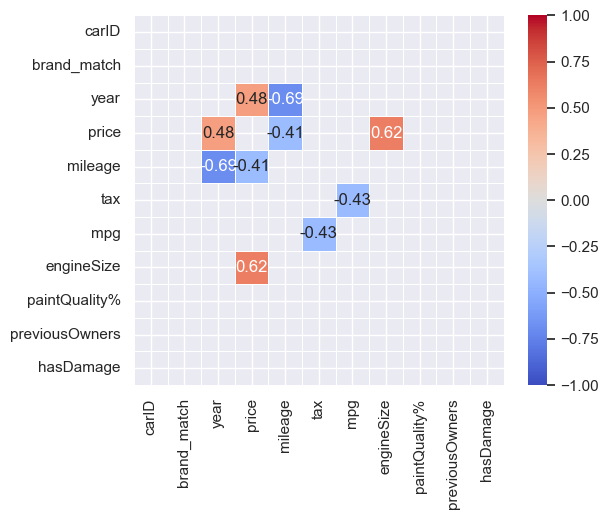

In [25]:
# we turned when engineSize = 0 to null so then we can impute the median for the specific model as we can´t have no engine in a car


clean_engine_size = df['engineSize'] == 0
df.loc[clean_engine_size, 'engineSize'] = np.nan
df['engineSize'].isna().sum()


has_damage_null = df['hasDamage'].isna()
df.loc[has_damage_null]

thr = 0.4
corr = df.corr(numeric_only=True)

mask = corr.abs() < thr                     # hide anything below threshold
# (optional) also hide the diagonal 1.0s:
mask.values[np.diag_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0,
            cmap='coolwarm', annot=True, fmt=".2f", square=True, linewidths=.5)
plt.show()

In [26]:
df.isnull().sum()
df.set_index('carID', inplace=True)

In [27]:
index_for_null_brand_and_null_model = df[(df['Brand'].isnull()) & (df['model'].isnull())].index
df = df.drop(index = index_for_null_brand_and_null_model) 
# this cars will be impossible to find which cars are


In [28]:
len(df)
brand_null = df[df['Brand'].isnull()].index
df.drop(index = brand_null, inplace = True)
len(df)
#we drop this as well as the models were not clear, so we could not assign them into a brand
#df.isnull().sum()


75933

In [29]:
# preencher NAN's da coluna hasDamage com 1

df['hasDamage'] = df['hasDamage'].fillna(1)

In [30]:
X = df.drop('price', axis = 1)
y = df['price']

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, 
                                                  random_state = 42, 
                                                  shuffle = True)


In [32]:
df.isnull().sum()


Brand                0
model             1481
brand_match          0
year              1490
price                0
transmission      1522
mileage           1463
fuelType          1677
tax               7902
mpg               7924
engineSize        1695
paintQuality%     1523
previousOwners    1548
hasDamage            0
dtype: int64

In [33]:
## important after trying to solve this
null_dataset = df.copy()
model_null = df.loc[df['model'].isnull()].index
null_dataset= null_dataset.loc[model_null].copy()


In [34]:
import numpy as np
import pandas as pd

# start from your original df
df_cleaned = df.copy()

get_mode = lambda s: s.mode().iat[0] if not s.mode().empty else np.nan

# Brand+year -> model map (learned on train)
by_brand_year = (X_train.dropna(subset=['Brand','year','model'])
                   .groupby(['Brand','year'])['model']
                   .agg(get_mode))

# Brand -> model map (fallback, learned on train)
by_brand = (X_train.dropna(subset=['Brand','model'])
              .groupby('Brand')['model']
              .agg(get_mode))


In [35]:
def fill_model_using_train_maps(df, by_brand_year, by_brand):
    df = df.copy()
    mask = df['model'].isna()

    # Try Brand+year
    fill1 = (df.loc[mask, ['Brand','year']]
               .merge(by_brand_year.rename('fill'),
                      how='left', left_on=['Brand','year'], right_index=True)['fill'])
    df.loc[mask, 'model'] = fill1.to_numpy()

    # Fallback Brand-only
    mask = df['model'].isna()
    df.loc[mask, 'model'] = df.loc[mask, 'Brand'].map(by_brand)

    return df

X_train = fill_model_using_train_maps(X_train, by_brand_year, by_brand)
X_val   = fill_model_using_train_maps(X_val,   by_brand_year, by_brand)

In [36]:
X_val['model'].isna().sum()

0

In [37]:
get_median = lambda s: s.median(skipna=True) if s.notna().any() else np.nan

# 1A) Fill by Brand + model median
by_brand_model = (X_train.groupby(['Brand','model'])['year']
                   .agg(get_median))





In [38]:
def fill_year_using_train_maps(df, by_brand_model):
    df = df.copy()
    mask = df['year'].isna()

    # Try Brand+year
    fill1 = (df.loc[mask, ['Brand','model']]
               .merge(by_brand_model.rename('fill'),
                      how='left', left_on=['Brand','model'], right_index=True)['fill'])
    df.loc[mask, 'year'] = fill1.to_numpy()

    return df

X_train = fill_year_using_train_maps(X_train, by_brand_model)
X_val   = fill_year_using_train_maps(X_val, by_brand_model)

In [39]:
X_train['year'].isna().sum()
X_val['year'].isna().sum()

0

In [40]:
X_train.isna().sum()

Brand                0
model                0
brand_match          0
year                 0
transmission      1075
mileage            998
fuelType          1182
tax               5516
mpg               5549
engineSize        1182
paintQuality%     1057
previousOwners    1109
hasDamage            0
dtype: int64

In [41]:
### now lets clean transmission
get_mode = lambda s: s.mode().iat[0] if not s.mode().empty else np.nan

# Brand + year -> model map (learned on train)
by_brand_model_year = (X_train.dropna(subset = 'transmission').groupby(['Brand','model','year'])['transmission']
                   .agg(get_mode))
by_brand_model = (X_train.dropna(subset = 'mileage').groupby(['Brand','model'])['transmission']
                   .agg(get_mode))

def fill_transmission_using_train_maps(df, by_brand_year, by_brand_model):
    df = df.copy()
    mask = df['transmission'].isna()

    # Try Brand+year
    fill1 = (df.loc[mask, ['Brand','model','year']]
               .merge(by_brand_model_year.rename('fill'),
                      how='left', left_on=['Brand','model','year'], right_index=True)['fill'])
    df.loc[mask, 'transmission'] = fill1.to_numpy()
    mask = df['transmission'].isna()
    
    keys = pd.MultiIndex.from_frame(df.loc[mask, ['Brand','model']])
    df.loc[mask, 'transmission'] = by_brand_model.reindex(keys).to_numpy()
    return df

X_train = fill_transmission_using_train_maps(X_train, by_brand_model_year, by_brand_model)
X_val   = fill_transmission_using_train_maps(X_val,   by_brand_model_year, by_brand_model)






In [42]:
### now clean mileage here makes more sense to use median for the year
get_median = lambda s: s.median(skipna=True) if s.notna().any() else np.nan

# 1A) Fill by Brand + model median
by_year = (X_train.dropna(subset = ['mileage']).groupby(['year'])['mileage']
                   .agg(get_median))

def fill_mileage_using_train_maps(df, by_year):
    df = df.copy()
    mask = df['mileage'].isna()

    # Try Brand+year
    fill1 = (df.loc[mask, ['year']]
               .merge(by_year.rename('fill'),
                      how='left', left_on=['year'], right_index=True)['fill'])
    df.loc[mask, 'mileage'] = fill1.to_numpy()

    return df

X_train = fill_mileage_using_train_maps(X_train, by_year)
X_val   = fill_mileage_using_train_maps(X_val, by_year)



In [43]:
X_val.isna().sum()

Brand                0
model                0
brand_match          0
year                 0
transmission         0
mileage              0
fuelType           495
tax               2386
mpg               2375
engineSize         513
paintQuality%      466
previousOwners     439
hasDamage            0
dtype: int64

In [44]:
X_train['fuelType'].unique()


array(['Diesel', 'Petrol', 'Hybrid', nan, 'Electric'], dtype=object)

In [45]:
### now lets clean transmission
get_mode = lambda s: s.mode().iat[0] if not s.mode().empty else np.nan

# Brand + year -> model map (learned on train)
by_brand_model_year = (X_train.dropna(subset = 'fuelType').groupby(['Brand','model','year'])['fuelType']
                   .agg(get_mode))
by_brand_model = (X_train.dropna(subset = 'fuelType').groupby(['Brand','model'])['fuelType']
                   .agg(get_mode))
by_brand = (X_train.dropna(subset = 'fuelType').groupby(['Brand'])['fuelType']
                   .agg(get_mode))

def fill_fuelType_using_train_maps(df, by_brand_year, by_brand_model, by_brand):
    df = df.copy()
    mask = df['fuelType'].isna()

    # Try Brand+year
    fill1 = (df.loc[mask, ['Brand','model','year']]
               .merge(by_brand_model_year.rename('fill'),
                      how='left', left_on=['Brand','model','year'], right_index=True)['fill'])
    df.loc[mask, 'fuelType'] = fill1.to_numpy()
    mask = df['fuelType'].isna()
    
    keys = pd.MultiIndex.from_frame(df.loc[mask, ['Brand','model']])
    df.loc[mask, 'fuelType'] = by_brand_model.reindex(keys).to_numpy()

    mask = df['fuelType'].isna()
    df.loc[mask, 'fuelType'] = df.loc[mask, 'Brand'].map(by_brand)


    return df

X_train = fill_fuelType_using_train_maps(X_train, by_brand_model_year, by_brand_model, by_brand)
X_val   = fill_fuelType_using_train_maps(X_val,   by_brand_model_year, by_brand_model, by_brand)

In [46]:
X_train.loc[X_train['fuelType'].isna(), 'Brand'].values
X_train['fuelType'].unique()

array(['Diesel', 'Petrol', 'Hybrid', 'Electric'], dtype=object)

In [47]:
X_train.query("model == 'prius'")['fuelType'].value_counts()

Hybrid    112
Name: fuelType, dtype: int64

In [48]:
X_val.isnull().sum()

Brand                0
model                0
brand_match          0
year                 0
transmission         0
mileage              0
fuelType             0
tax               2386
mpg               2375
engineSize         513
paintQuality%      466
previousOwners     439
hasDamage            0
dtype: int64

In [49]:
df.describe()

,brand_match,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,75933.000000,74443.000000,75933.000000,74470.000000,68031.000000,68009.000000,74238.000000,74410.00000,74385.000000,75933.000000
mean,0.977533,2017.096785,16880.572017,23471.163328,120.833708,55.200307,1.664313,64.46436,2.014976,0.020386
std,0.148198,2.206154,9736.647776,21637.146799,64.566261,16.345545,0.567382,20.73581,1.437302,0.141319
min,0.000000,1970.000000,450.000000,1.000000,0.000000,1.100000,0.100000,2.00000,0.000000,0.000000
25%,1.000000,2016.000000,10200.000000,7612.000000,125.000000,46.300000,1.200000,47.00000,1.000000,0.000000
50%,1.000000,2017.000000,14698.000000,17529.000000,145.000000,54.300000,1.600000,65.00000,2.000000,0.000000
75%,1.000000,2019.000000,20950.000000,32836.000000,145.000000,62.800000,2.000000,82.00000,3.000000,0.000000
max,1.000000,2024.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000,100.00000,6.000000,1.000000


In [50]:
#LIMPAR tax

get_median = lambda s: s.median(skipna=True) if s.notna().any() else np.nan

# Brand + model + year -> (learned on train)
by_brand_model_year = (X_train.dropna(subset=['tax'])
                       .groupby(['Brand','model','year'])['tax']
                       .agg(get_median))
by_brand_model = (X_train.dropna(subset=['tax'])
                  .groupby(['Brand','model'])['tax']
                  .agg(get_median))
by_brand = (X_train.dropna(subset=['tax'])
            .groupby(['Brand'])['tax']
            .agg(get_median))

def fill_tax_using_train_maps(df, by_brand_model_year, by_brand_model, by_brand):
    df = df.copy()
    mask = df['tax'].isna()

    # Try Brand+Model+Year
    fill1 = (df.loc[mask, ['Brand','model','year']]
               .merge(by_brand_model_year.rename('fill'),
                      how='left', left_on=['Brand','model','year'], right_index=True)['fill'])
    df.loc[mask, 'tax'] = fill1.to_numpy()
    mask = df['tax'].isna()
    
    # Try Brand+Model
    keys = pd.MultiIndex.from_frame(df.loc[mask, ['Brand','model']])
    df.loc[mask, 'tax'] = by_brand_model.reindex(keys).to_numpy()

    # Try Brand
    mask = df['tax'].isna()
    df.loc[mask, 'tax'] = df.loc[mask, 'Brand'].map(by_brand)

    return df


X_train = fill_tax_using_train_maps(X_train, by_brand_model_year, by_brand_model, by_brand)
X_val   = fill_tax_using_train_maps(X_val, by_brand_model_year, by_brand_model, by_brand)


In [51]:
#LIMPAR mpg

get_median = lambda s: s.median(skipna=True) if s.notna().any() else np.nan

# 1A) Fill by Brand + model median
by_brand_model_year = (X_train.dropna(subset = 'mpg').groupby(['Brand','model','year'])['mpg']
                   .agg(get_median))
by_brand_model = (X_train.dropna(subset = 'mpg').groupby(['Brand','model'])['mpg']
                   .agg(get_median))
by_brand = (X_train.dropna(subset = 'mpg').groupby(['Brand'])['mpg']
                   .agg(get_median))
def fill_mpg_train_maps(df, by_brand_model_year, by_brand_model):
    df = df.copy()
    mask = df['mpg'].isna()

    # Try Brand+year
    fill1 = (df.loc[mask, ['Brand', 'model', 'year']]
               .merge(by_brand_model_year.rename('fill'),
                      how='left', left_on=['Brand', 'model', 'year'], right_index=True)['fill'])
    df.loc[mask, 'mpg'] = fill1.to_numpy()

    mask = df['mpg'].isna()

    # Try Brand+year
    fill2 = (df.loc[mask, ['Brand', 'model']]
               .merge(by_brand_model.rename('fill'),
                      how='left', left_on=['Brand', 'model'], right_index=True)['fill'])
    df.loc[mask, 'mpg'] = fill2.to_numpy()



    return df

X_train = fill_mpg_train_maps(X_train, by_brand_model_year, by_brand_model)
X_val   = fill_mpg_train_maps(X_val, by_brand_model_year,by_brand_model)

In [52]:
#LIMPAR engineSize

get_median = lambda s: s.median(skipna=True) if s.notna().any() else np.nan

# Brand + model + year -> (learned on train)
by_brand_model_year = (X_train.dropna(subset=['engineSize'])
                       .groupby(['Brand','model','year'])['engineSize']
                       .agg(get_median))
by_brand_model = (X_train.dropna(subset=['engineSize'])
                  .groupby(['Brand','model'])['engineSize']
                  .agg(get_median))
by_brand = (X_train.dropna(subset=['engineSize'])
            .groupby(['Brand'])['engineSize']
            .agg(get_median))

def fill_engineSize_using_train_maps(df, by_brand_model_year, by_brand_model, by_brand):
    df = df.copy()
    mask = df['engineSize'].isna()

    # Try Brand+Model+Year
    fill1 = (df.loc[mask, ['Brand','model','year']]
               .merge(by_brand_model_year.rename('fill'),
                      how='left', left_on=['Brand','model','year'], right_index=True)['fill'])
    df.loc[mask, 'engineSize'] = fill1.to_numpy()
    mask = df['engineSize'].isna()
    
    # Try Brand+Model
    keys = pd.MultiIndex.from_frame(df.loc[mask, ['Brand','model']])
    df.loc[mask, 'engineSize'] = by_brand_model.reindex(keys).to_numpy()

    # Try Brand
    mask = df['engineSize'].isna()
    df.loc[mask, 'engineSize'] = df.loc[mask, 'Brand'].map(by_brand)

    return df

X_train = fill_engineSize_using_train_maps(X_train, by_brand_model_year, by_brand_model, by_brand)
X_val   = fill_engineSize_using_train_maps(X_val, by_brand_model_year, by_brand_model, by_brand)


In [53]:
#LIMPAR paintQuality% 

get_median = lambda s: s.median(skipna=True) if s.notna().any() else np.nan

# Brand + model + year -> (learned on train)
by_brand_model_year = (X_train.dropna(subset=['paintQuality%'])
                       .groupby(['Brand','model','year'])['paintQuality%']
                       .agg(get_median))
by_brand_model = (X_train.dropna(subset=['paintQuality%'])
                  .groupby(['Brand','model'])['paintQuality%']
                  .agg(get_median))
by_brand = (X_train.dropna(subset=['paintQuality%'])
            .groupby(['Brand'])['paintQuality%']
            .agg(get_median))

def fill_paintQuality_using_train_maps(df, by_brand_model_year, by_brand_model, by_brand):
    df = df.copy()
    mask = df['paintQuality%'].isna()

    # Try Brand+Model+Year
    fill1 = (df.loc[mask, ['Brand','model','year']]
               .merge(by_brand_model_year.rename('fill'),
                      how='left', left_on=['Brand','model','year'], right_index=True)['fill'])
    df.loc[mask, 'paintQuality%'] = fill1.to_numpy()
    mask = df['paintQuality%'].isna()
    
    # Try Brand+Model
    keys = pd.MultiIndex.from_frame(df.loc[mask, ['Brand','model']])
    df.loc[mask, 'paintQuality%'] = by_brand_model.reindex(keys).to_numpy()

    # Try Brand
    mask = df['paintQuality%'].isna()
    df.loc[mask, 'paintQuality%'] = df.loc[mask, 'Brand'].map(by_brand)

    return df

X_train = fill_paintQuality_using_train_maps(X_train, by_brand_model_year, by_brand_model, by_brand)
X_val   = fill_paintQuality_using_train_maps(X_val, by_brand_model_year, by_brand_model, by_brand)

In [54]:
#LIMPAR previousOwners

get_median = lambda s: s.median(skipna=True) if s.notna().any() else np.nan

# 1A) Fill by Brand + model median
by_brand_model_year = (X_train.dropna(subset = 'previousOwners').groupby(['Brand','model','year'])['previousOwners']
                   .agg(get_median))
by_brand_model = (X_train.dropna(subset = 'previousOwners').groupby(['Brand','model'])['previousOwners']
                   .agg(get_median))
by_brand = (X_train.dropna(subset = 'previousOwners').groupby(['Brand'])['previousOwners']
                   .agg(get_median))
def fill_previousOwners_train_maps(df, by_brand_model_year, by_brand_model, by_brand):
    df = df.copy()
    mask = df['previousOwners'].isna()

    # Try Brand+year
    fill1 = (df.loc[mask, ['Brand', 'model', 'year']]
               .merge(by_brand_model_year.rename('fill'),
                      how='left', left_on=['Brand', 'model', 'year'], right_index=True)['fill'])
    df.loc[mask, 'previousOwners'] = fill1.to_numpy()

    mask = df['previousOwners'].isna()

    # Try Brand+year
    fill2 = (df.loc[mask, ['Brand', 'model']]
               .merge(by_brand_model.rename('fill'),
                      how='left', left_on=['Brand', 'model'], right_index=True)['fill'])
    df.loc[mask, 'previousOwners'] = fill2.to_numpy()
    mask = df['previousOwners'].isna()
    fill3 = (df.loc[mask, ['Brand']]
               .merge(by_brand.rename('fill'),
                      how='left', left_on=['Brand'], right_index=True)['fill'])
    df.loc[mask, 'previousOwners'] = fill3.to_numpy()



    return df

X_train = fill_previousOwners_train_maps(X_train, by_brand_model_year, by_brand_model, by_brand)
X_val   = fill_previousOwners_train_maps(X_val, by_brand_model_year,by_brand_model, by_brand)

In [55]:
X_val.isna().sum()

Brand             0
model             0
brand_match       0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
hasDamage         0
dtype: int64

In [56]:
#turning object int categories

for col in df.columns:
    if df[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

In [57]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22780 entries, 10960 to 829
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Brand           22780 non-null  category
 1   model           22780 non-null  category
 2   brand_match     22780 non-null  float64 
 3   year            22780 non-null  float64 
 4   transmission    22780 non-null  category
 5   mileage         22780 non-null  float64 
 6   fuelType        22780 non-null  category
 7   tax             22780 non-null  float64 
 8   mpg             22780 non-null  float64 
 9   engineSize      22780 non-null  float64 
 10  paintQuality%   22780 non-null  float64 
 11  previousOwners  22780 non-null  float64 
 12  hasDamage       22780 non-null  float64 
dtypes: category(4), float64(9)
memory usage: 1.9 MB


In [58]:
X_val.describe()

,brand_match,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,22780.000000,22780.000000,22780.000000,22780.000000,22780.000000,22780.000000,22780.000000,22780.000000,22780.000000
mean,0.978183,2017.087730,23521.759482,120.999561,55.501556,1.665077,64.383209,1.996510,0.019140
std,0.146090,2.223965,21712.366984,63.874148,15.372396,0.567405,20.565146,1.423426,0.137019
min,0.000000,1970.000000,1.000000,0.000000,1.100000,0.100000,2.000000,0.000000,0.000000
25%,1.000000,2016.000000,7700.000000,125.000000,47.100000,1.200000,47.000000,1.000000,0.000000
50%,1.000000,2017.000000,17759.500000,145.000000,55.400000,1.600000,65.000000,2.000000,0.000000
75%,1.000000,2019.000000,32698.500000,145.000000,62.800000,2.000000,82.000000,3.000000,0.000000
max,1.000000,2024.000000,323000.000000,580.000000,470.800000,6.600000,100.000000,6.000000,1.000000


In [59]:
X_train['year'] = X_train['year'].astype('int')
X_train['year'].value_counts()
X_val['year'] = X_val['year'].astype('int')
X_val['year'].value_counts()

2019    6023
2017    5257
2016    3450
2018    3167
2015    1712
2020     999
2014     857
2013     590
2011     161
2012     130
2010     113
2009      69
2023      51
2008      50
2007      36
2024      32
2005      22
2006      19
2004      10
2002       9
2003       8
2001       5
1999       3
2000       3
1970       2
1998       1
1996       1
Name: year, dtype: int64

### After cleaning

In [60]:
X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_num.drop('hasDamage', axis = 1, inplace = True)

X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
X_train_cat['hasDamage'] = X_train['hasDamage']

# Repeat for Validation

X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)
X_val_num.drop('hasDamage', axis = 1, inplace = True)

X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)
X_val_cat['hasDamage'] = X_val['hasDamage']

In [61]:
#Normalizing by MinMaxScaler 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num) 
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index) #Convert the array to a pandas dataframe
X_train_num_scaled.head(3)

,brand_match,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,,
75177,1.0,0.962963,0.045733,0.250000,0.103257,0.311475,0.540816,0.000000
27964,1.0,0.814815,0.029970,0.258621,0.107090,0.147541,0.479592,0.666667
38304,1.0,0.851852,0.000060,0.250000,0.091548,0.196721,0.647959,0.333333


In [62]:
#Applying to validation too

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)
X_val_num_scaled.head(3)

,brand_match,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,,
10960,1.0,0.814815,0.046619,0.25,0.101341,0.311475,0.571429,0.166667
13463,1.0,0.777778,0.043842,0.25,0.137535,0.311475,0.520408,0.500000
47962,1.0,0.740741,0.133489,0.25,0.113264,0.213115,0.632653,0.333333


In [63]:
X_train_num_scaled.var() #checking 

brand_match       0.022229
year              0.006470
mileage           0.007330
tax               0.011923
mpg               0.001128
engineSize        0.008572
paintQuality%     0.043878
previousOwners    0.056294
dtype: float64

In [64]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT important for Prediction. (Discard {0} from model)".format(var)
    print(result)

for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

Brand is IMPORTANT for Prediction
model is IMPORTANT for Prediction
transmission is NOT important for Prediction. (Discard transmission from model)
fuelType is IMPORTANT for Prediction
hasDamage is IMPORTANT for Prediction


### Start Modelling

In [65]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [66]:
#no of features
nof_list=np.arange(1,len(X_train_num_scaled.columns)+1)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LinearRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_num_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on validation data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 8
Score with 8 features: 0.669950


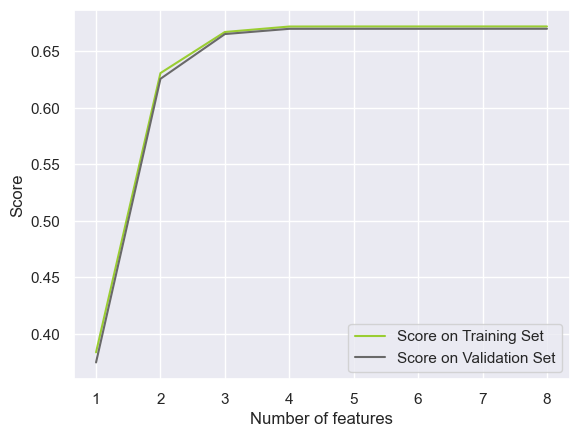

In [67]:
plt.plot(list(range(1,9)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,9)), val_score_list, label="Score on Validation Set", color='dimgray')
plt.xlabel("Number of features")
plt.ylabel("Score")
plt.legend()
plt.show()


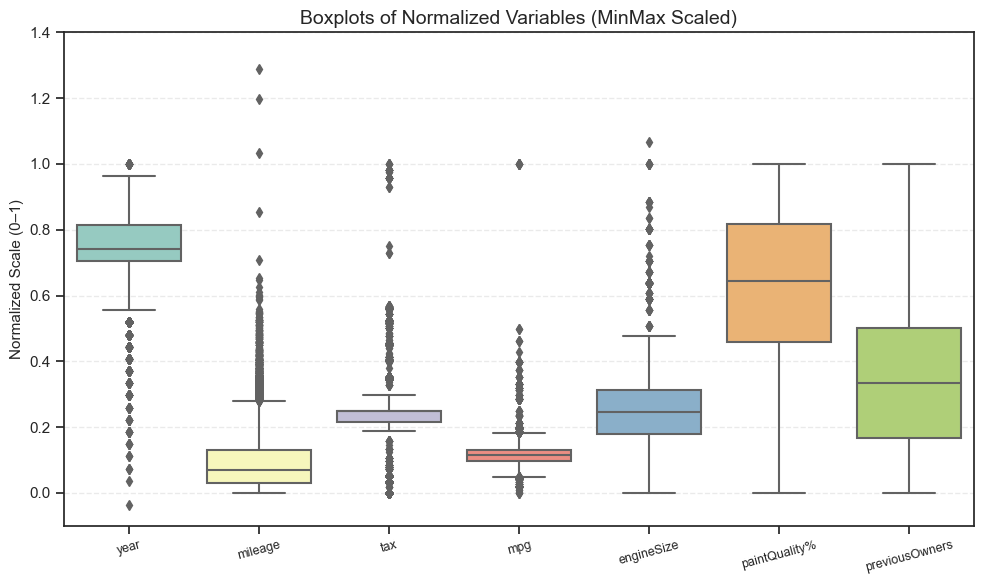

In [79]:
#BOXPLOTS 

# Garantir que X_val_num é DataFrame (caso seja array numpy)
X_val_num = pd.DataFrame(X_val_num_scaled, columns=['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners'])

# Criar figure e eixos
plt.figure(figsize=(10,6))

# Plot de todos os boxplots
sns.boxplot(data=X_val_num, palette='Set3')

# Título e formatação
plt.title('Boxplots of Normalized Variables (MinMax Scaled)', fontsize=14)
plt.ylabel('Normalized Scale (0–1)', fontsize=11)
plt.ylim(-0.1, 1.4)  
plt.xticks(rotation=15, fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.show()


In [15]:
#Numerical Data
import pandas as pd

num_features = ['tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'age', 'log_mileage']

#Results
spearman_keep = ['tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners'] #age and log_mileage: corr -0.78
rfe_lr_keep = ['tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'age', 'log_mileage'] #keep all
#rfe_svc_keep = ['tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'age', 'log_mileage'] #completar
lasso_keep = ['tax', 'mpg', 'engineSize', 'paintQuality%', 'age', 'log_mileage'] #previousOwners: coef 0 

def decision(var, kept_list):
    return "Keep" if var in kept_list else "Discard"

table = pd.DataFrame({
    'Numerical Variable': num_features,
    'Spearman': [decision(f, spearman_keep) for f in num_features],
    'RFE LR': [decision(f, rfe_lr_keep) for f in num_features],
    #'RFE SVM': [decision(f, rfe_svc_keep) for f in num_features],
    'Lasso': [decision(f, lasso_keep) for f in num_features],
})

#Suggestion: 3 or more keep's = keep, 3 or more discards's = discard, 2 vs 2 = try both ways
def what_to_do(row):
    keep_count = sum(v == "Keep" for v in row[1:])
    if keep_count >= 3:
        return "Include"
    elif keep_count == 2:
        return "Try with and without"
    else:
        return "Discard"

table["What to do?"] = table.apply(what_to_do, axis=1)
table

,Numerical Variable,Spearman,RFE LR,Lasso,What to do?
0,tax,Keep,Keep,Keep,Include
1,mpg,Keep,Keep,Keep,Include
2,engineSize,Keep,Keep,Keep,Include
3,paintQuality%,Keep,Keep,Keep,Include
4,previousOwners,Keep,Keep,Discard,Try with and without
5,age,Discard,Keep,Keep,Try with and without
6,log_mileage,Discard,Keep,Keep,Try with and without


In [13]:
#Categorical Data

cat_features = ['Brand', 'model', 'transmission', 'fuelType', 'hasDamage']

#Results from Chi-Square
chi_square_results = {
    'Brand': 'Keep',
    'model': 'Keep',
    'transmission': 'Discard',
    'fuelType': 'Keep',
    'hasDamage': 'Discard'
}

categorical_table = pd.DataFrame({
    'Categorical Variable': cat_features,
    'Chi-Square': [chi_square_results[f] for f in cat_features]
})

categorical_table

,Categorical Variable,Chi-Square
0,Brand,Keep
1,model,Keep
2,transmission,Discard
3,fuelType,Keep
4,hasDamage,Discard
